In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cn_levels = [1,3,6]
p_values1 = pd.read_csv(f"IV_test_results/increased_confounding/LDAG_true_source_conf_{1}.csv", index_col=0)
p_values3 = pd.read_csv(f"IV_test_results/increased_confounding/LDAG_true_source_conf_{3}.csv", index_col=0)
p_values6 = pd.read_csv(f"IV_test_results/increased_confounding/LDAG_true_source_conf_{6}.csv", index_col=0)

p_values1["Confounding"] = 1
p_values3["Confounding"] = 3
p_values6["Confounding"] = 6

In [3]:
p_values1

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Confounding
1,0,0.000,0.540,0.568,0.380,0.472,0.516,0.368,0.720,0.004,1
2,1,0.000,0.328,0.508,0.468,0.308,0.440,0.412,0.000,0.000,1
3,2,1.000,0.784,0.416,0.620,0.996,0.492,0.644,0.976,0.000,1
4,3,0.000,0.396,0.580,0.516,0.640,0.620,0.324,0.004,0.000,1
5,4,0.488,0.548,0.544,0.404,0.480,0.556,0.480,0.932,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...
96,95,0.000,0.408,0.388,0.440,0.392,0.536,0.620,1.000,0.000,1
97,96,0.000,0.492,0.448,0.364,0.584,0.568,0.576,0.872,0.000,1
98,97,0.016,0.532,0.540,0.516,0.560,0.456,0.488,0.544,0.020,1
99,98,0.964,0.464,0.500,0.560,0.456,0.376,0.428,0.000,0.000,1


In [4]:
new_col_names = ["seed"]
new_col_names.append("confounder_source")
for x in range(2,p_values1.shape[1]-3):
    new_col_names.append(f"control_source_{x-1}")
new_col_names.append("treatment_source")
new_col_names.append("outcome_source")
new_col_names.append("Confounding")


In [5]:
p_values1.columns = new_col_names
p_values3.columns = new_col_names
p_values6.columns = new_col_names

In [6]:
merged_df = pd.concat([p_values1, p_values3, p_values6], axis= 0)

In [7]:
merged_df.shape

(300, 11)

In [8]:
long_df = merged_df.melt(id_vars=["seed", "Confounding"])

In [9]:
long_df

,seed,Confounding,variable,value
0,0,1,confounder_source,0.000
1,1,1,confounder_source,0.000
2,2,1,confounder_source,1.000
3,3,1,confounder_source,0.000
4,4,1,confounder_source,0.488
...,...,...,...,...
2695,95,6,outcome_source,0.000
2696,96,6,outcome_source,0.096
2697,97,6,outcome_source,0.216
2698,98,6,outcome_source,0.000


In [10]:
long_df_subset = long_df.loc[long_df["variable"].isin(["confounder_source","control_source_1", "treatment_source", "Confounding"])]

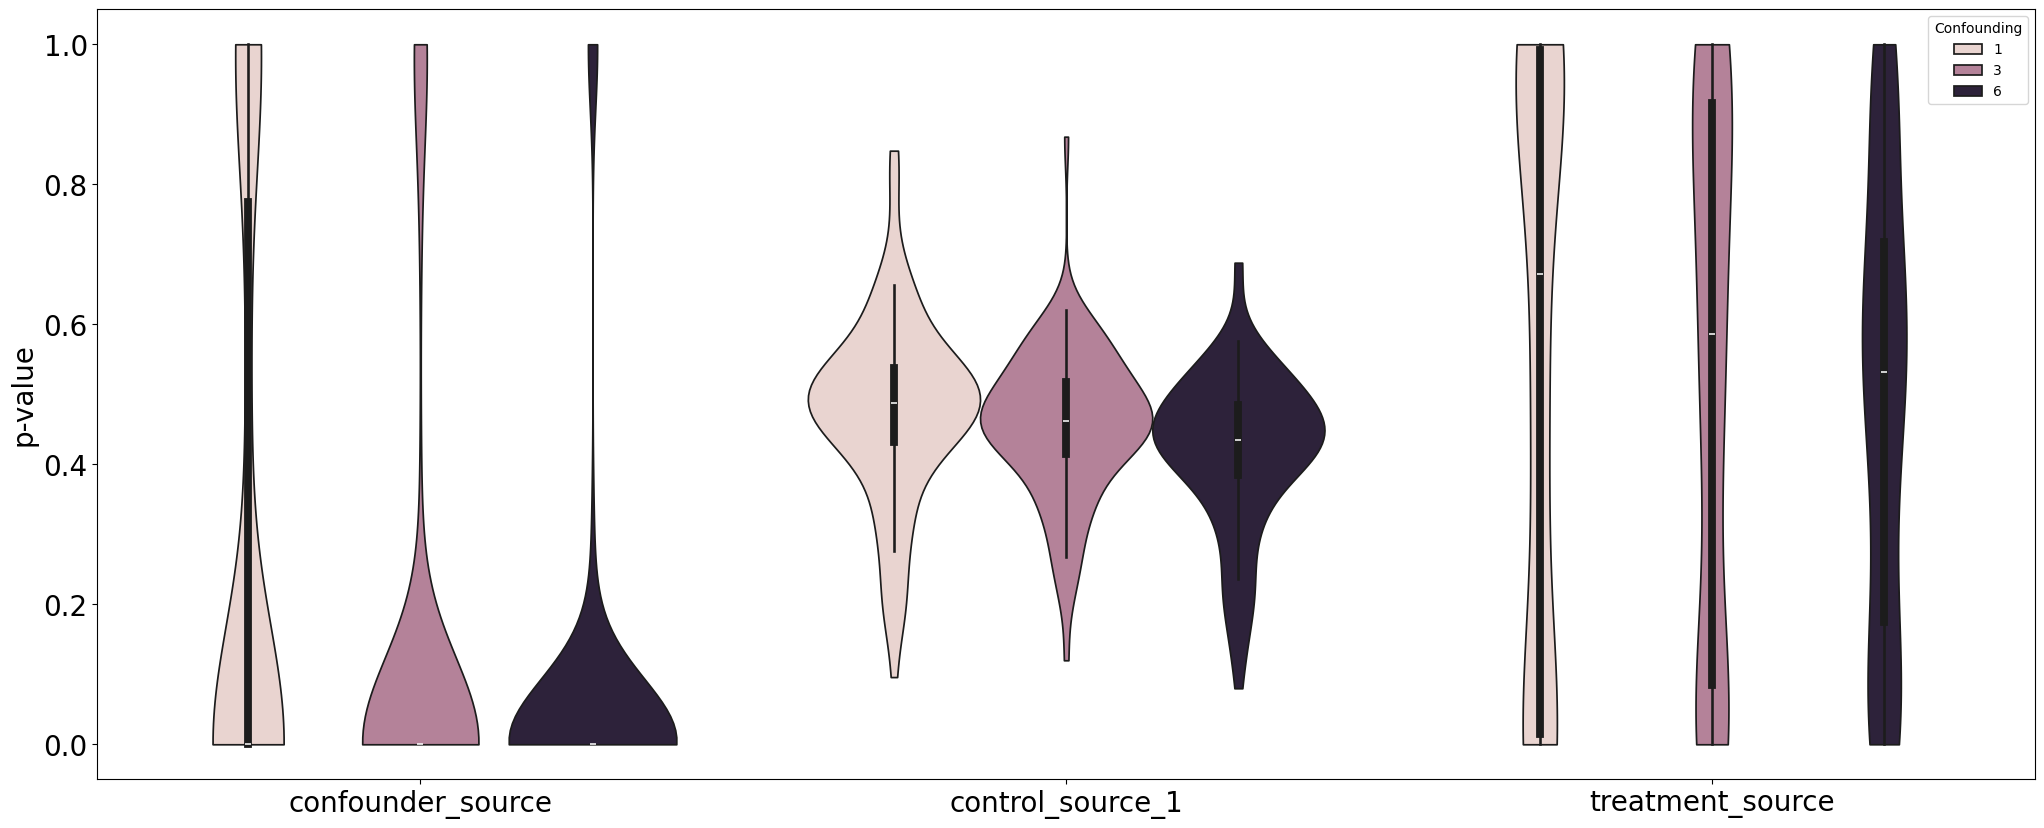

In [11]:
plt.figure(figsize= (25,10))
#plt.title("Distribution of the p-values for different TRUE sources, H0: source is a valid instrument for the treatment effect")
sns.violinplot(long_df_subset, x = "variable", y = "value", hue="Confounding" , inner = "box", cut = 0)
plt.xlabel("")
plt.ylabel("p-value", fontsize = 20)
plt.xticks(fontsize=20)  
plt.yticks(fontsize =20)

plt.show()

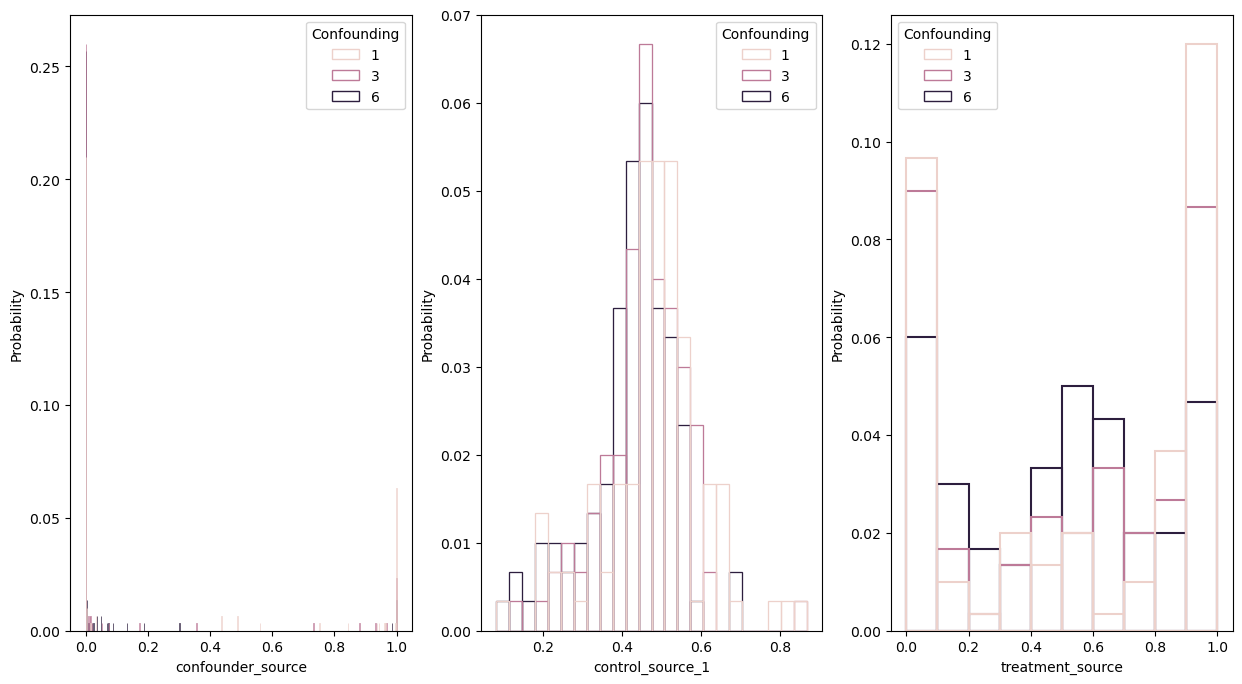

In [12]:
fg, ax = plt.subplots(1,3, figsize = (15,8))
cols = ["confounder_source","control_source_1", "treatment_source"]
for i in range(3):
    sns.histplot(merged_df, x = cols[i], hue = "Confounding", ax = ax[i] ,fill = False, stat ="probability")

plt.show()

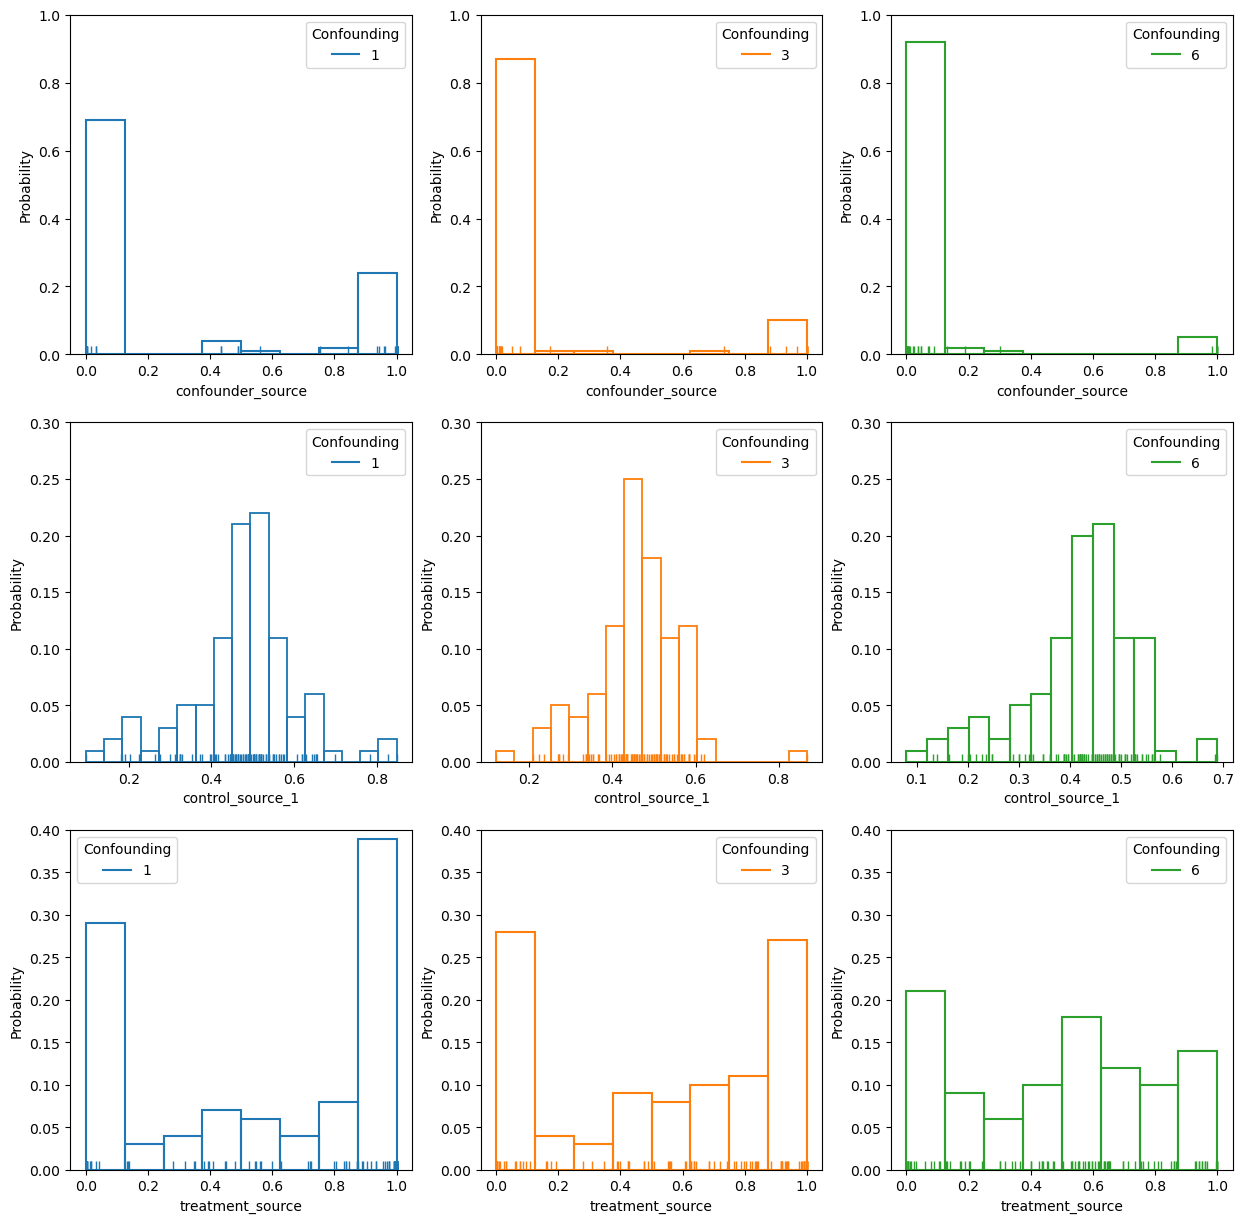

In [13]:
fg, ax = plt.subplots(3,3, figsize = (15,15))
cols = ["confounder_source","control_source_1", "treatment_source"]
palette = dict(zip(cn_levels, sns.color_palette("tab10", len(cn_levels))))
lims = [1,.3, .4]
for i in range(3):
    for j in range(3):
        sns.histplot(merged_df[merged_df["Confounding"] == cn_levels[j]], x=cols[i], ax=ax[i, j], fill=False, stat="probability", hue="Confounding", palette=palette)
        sns.rugplot(merged_df[merged_df["Confounding"] == cn_levels[j]], x=cols[i], ax=ax[i, j], hue="Confounding", palette=palette)
    
        ax[i, j].set_ylim(0, lims[i])  # Fixing the y-axis limits for each subplot
plt.show()

# IV test on estimated sources

Text(0.5, 0.98, 'CausalVarEM')

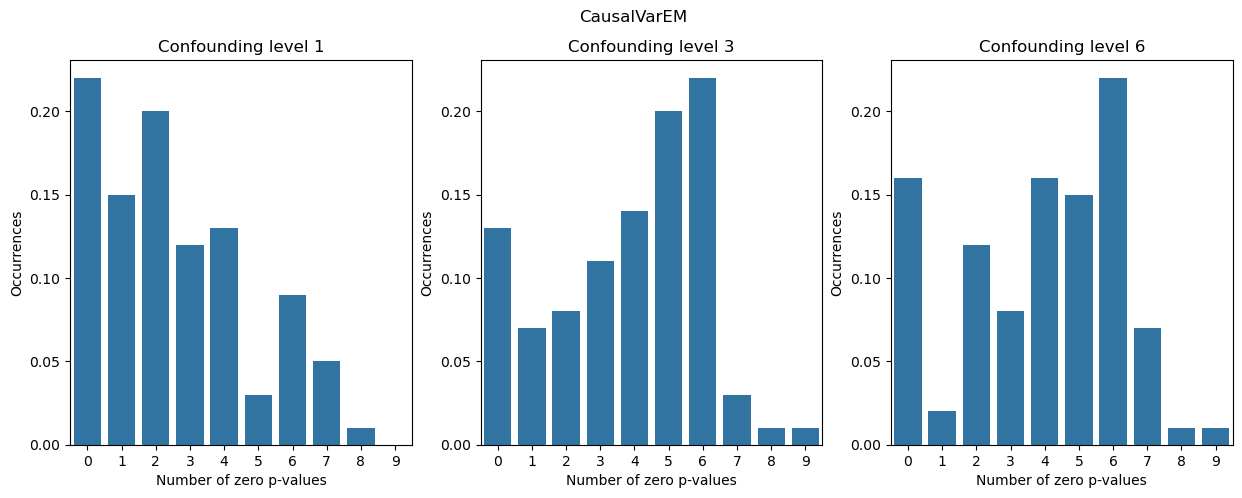

In [14]:
conf_values = [1, 3, 6]
output = {}

def calculateConfoundingCounts(conf_values, output, method ):
    for conf in conf_values:
        path = f"IV_test_results/increased_confounding/LDAG_{method}_conf_{conf}.csv"
        p_vals = pd.read_csv(path, index_col=0)
        p_vals = p_vals.iloc[:, 1:p_vals.shape[1]]
        count_values = p_vals.apply(lambda x: np.sum(x == 0), axis=1).value_counts(sort=True)
        output[conf] = count_values

    output_df = pd.DataFrame(output)
    output_df.fillna(0, inplace=True)
    return output_df
output_df = calculateConfoundingCounts(conf_values, output, "CausalVarEM")

def plot_p_counts(conf_values, output_df):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, conf in enumerate(conf_values):
        sns.barplot(x=output_df.index, y=output_df[conf]/100, ax=ax[i], )
        ax[i].set_title(f"Confounding level {conf}")
        ax[i].set_xlabel("Number of zero p-values")
        ax[i].set_ylabel("Occurrences")

plot_p_counts(conf_values, output_df)
plt.suptitle("CausalVarEM")

Text(0.5, 0.98, 'VarEM')

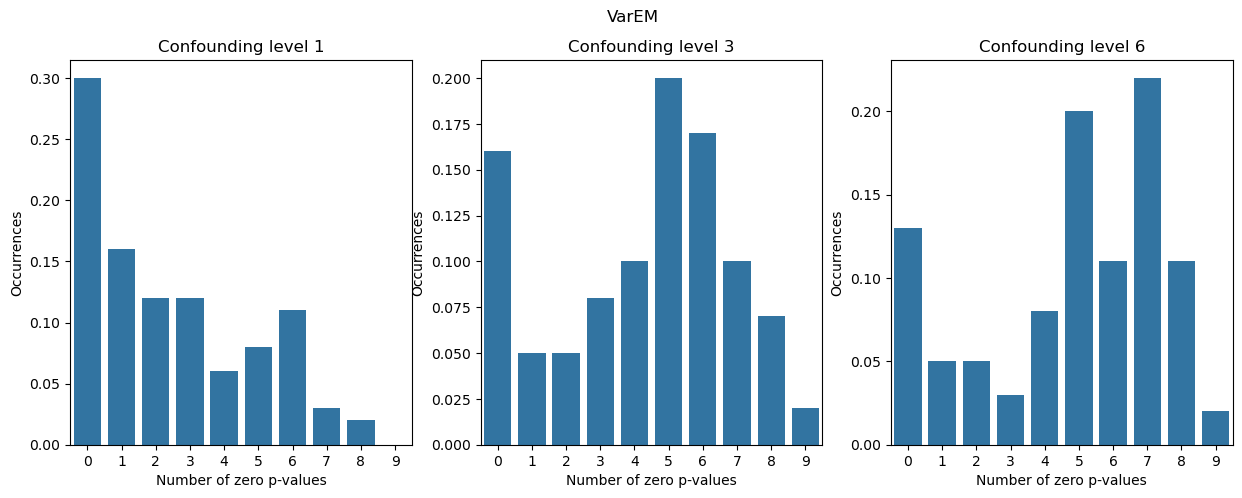

In [15]:
conf_values = [1,3, 6]
output = {}

output_df = calculateConfoundingCounts(conf_values, output, "VarEM")

plot_p_counts(conf_values, output_df)
plt.suptitle("VarEM")

In [108]:
output_df

,1,3,6
0,22.0,13,16.0
1,15.0,5,3.0
2,20.0,11,10.0
3,12.0,10,11.0
4,13.0,17,14.0
5,3.0,18,17.0
6,9.0,21,19.0
7,5.0,2,9.0
8,1.0,2,0.0
9,0.0,1,1.0
